In [1]:
#export JULIA_NUM_THREADS=8
Threads.nthreads()

1

In [2]:
using Statistics
using Plots
using LaTeXStrings
using JLD2

In [3]:
pgfplotsx()

function plot_lattice(lattice::Array{Int8}, T::Number, fn::String = "lattice.tex")
    lat = heatmap(lattice,aspect_ratio=1.0,size=(800,800),grid=false,framestyle=(:box), colormap_name = "hot",legend=false) #blue=-1, red=1
    l::Int = size(lattice)[1]::Int
    hline!(lat,0.5:1:l+0.5, line=(:black))
    vline!(lat,0.5:1:l+0.5, line=(:black))
    title!(lat,"L=$l, T=$T")
    savefig(lat, fn)
    plot(lat)
end
#plot_lattice(lattice,2.269)


plot_lattice (generic function with 2 methods)

In [15]:
 function ising(L::Int, T::Number; MCS=230_000::Int, to_plot::Bool=false)
    #initialize random lattice, and indexes
    lattice = rand(Int8[-1,1], L, L)
    #lattice = ones(Int8,L,L)
    next_I = collect(2:L+1)
    prev_I = collect(0:L-1)
    next_I[L]=1 
    prev_I[1] = L
    
    # compute boltzmann factor as Dict
    boltzmann_factor = Dict{Int,Float64}(ΔE => exp(-ΔE / T) for ΔE = -8:4:8)

    #initial arrays (returned)
    magnetizations = zeros(0)
    energies = zeros(0)

    for k=1 : MCS
        for i=1:L, j=1:L
        #metropolis algorithm
            ΔE::Int = 2 * lattice[i,j] * (lattice[next_I[i],j] + lattice[prev_I[i],j] + lattice[i,next_I[j]] + lattice[i,prev_I[j]])
            w::Float64 = min(1, boltzmann_factor[ΔE])
            if rand() ≤ w
                lattice[i,j] *= -1
            end
        end

        if (30_000 < k && k%100 == 0)
            m_k::Float64 = abs(mean(lattice))
            push!(magnetizations, m_k)
            E::Float64 = 0.0
            for i=1:L, j=1:L
                E += 0.5 * lattice[i,j] * (lattice[next_I[i],j] + lattice[prev_I[i],j] + lattice[i,next_I[j]] + lattice[i,prev_I[j]])
            end
            push!(energies, E)
        end
    end
    if (to_plot)
        plot_lattice(lattice, T, "lattice_L$(L)_T$(trunc(Int,T)).png")
    end
    return magnetizations, energies
end

ising (generic function with 1 method)

In [16]:
Ls=[6,20,70]
Ts=[0.05,2.269,8.0]
const k_B = 1.380_649e-23

function run_MC(Ls::Array{Int}, Ts::Array{Float64})
    result = Dict{Int, Dict{Char, Dict{Float64,Float64}}}(l => Dict(c => Dict() for c in ['m','χ','C']) for l in Ls)
    Threads.@threads for (L,T) in collect(Iterators.product(Ls,Ts))
            magnetizations, energies = ising(L,T,to_plot=false,MCS=430_000)

            #magnetizations = abs.(magnetizations) abs done in ising()

            result[L]['m'][T] = mean(magnetizations)                                                    # mean magnetization        <m>
            result[L]['χ'][T] = L^2 / T * var(magnetizations, mean=result[L]['m'][T], corrected=false)  # magnetic susceptibility    χ
            result[L]['C'][T] = 1.0 / L^2 / T^2 * var(energies, corrected=false)                        # heat capacity              C


            #println(Threads.threadid(),' ',L ,' ', T)
    end
    return result
end

function run_MC_one_thread(Ls::Array{Int},Ts::Array{Float64})
    for (L,T) in collect(Iterators.product(Ls,Ts))
        magnetizations, energies = @time ising(L, T, MCS=430_000, to_plot=true)
        println(Threads.threadid()," ",L,' ',T)
    end
end

run_MC_one_thread (generic function with 1 method)

In [27]:
Ls = [6,20,70]
Ts = cat(0.5:0.05:1.75, 1.8:0.005:2.7, 2.75:0.05:3.5, dims=1)
#Ts = cat(1.8:0.1:2.7, dims=1)
result_ret = @time run_MC(Ls,Ts)
#@save "result_ret_Ls_Ts_430_v3.jld2" result_ret Ls Ts

In [20]:
Ls = [70]
Ts = [0.05, 2.269, 8.00]
@time run_MC_one_thread(Ls,Ts)

 72.565827 seconds (561.04 k allocations: 35.001 MiB, 0.06% gc time)
1 70 0.05
101.916619 seconds (561.26 k allocations: 35.088 MiB, 0.03% gc time)
1 70 2.269
109.222192 seconds (561.34 k allocations: 35.062 MiB)
1 70 8.0
283.708523 seconds (1.68 M allocations: 105.175 MiB, 0.02% gc time)


In [3]:
#result = result_ret
#result[70]['χ']
plotlyjs()
plot()
for L in Ls
    plot!(result[L]['m'], markershape=:auto, label="L=$L", markersize=3, markerstrokealpha=0.1)
end
#vline!([2.269], label=L"T^*_c=2.269")
#display()
#ylims!(0.5e-24,3e-23)
xlabel!(L"T^*")
ylabel!(L"<m>")
title!("Magnetization as a function of reduced temperature - random initial conditions", titlefontsize=10)
#savefig("magnetization.tex")


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1631092343126184947\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-17560447183863550985\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1631092343126184947\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

<!DOCTYPE html>
 
 
 Plots.jl

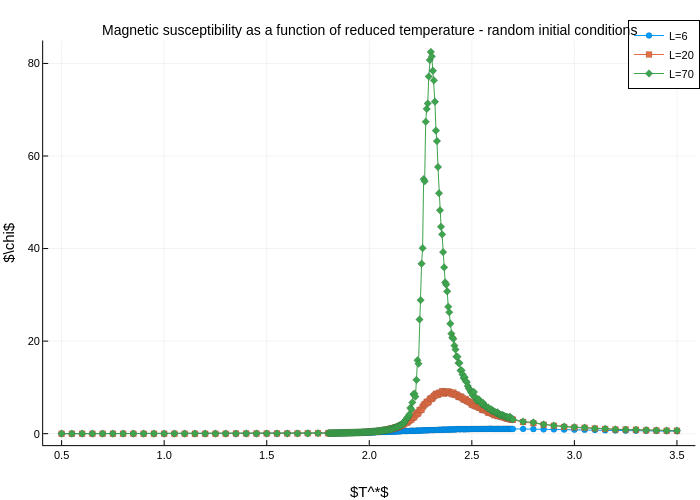

In [6]:
plot()
for L in Ls
    plot!(result[L]['χ'], markershape=:auto, label="L=$L", markersize=3, markerstrokealpha=0.1)
end
#vline!([2.269], label=L"T^*_c=2.269")
#display()
#ylims!(0.5e-24,3e-23)
xlabel!(L"T^*")
ylabel!(L"\chi")
title!("Magnetic susceptibility as a function of reduced temperature - random initial conditions", titlefontsize=10)
gui()
#savefig("magnetic_suscepitibility.tex")

In [5]:
plot()
for L in Ls
    plot!(result[L]['C'], markershape=:auto, label="L=$L", markersize=3, markerstrokealpha=0.1)
end
#vline!([2.269], label=L"T^*_c=2.269")
#display()
#ylims!(0.5e-24,3e-23)
xlabel!(L"T^*")
ylabel!(L"C \quad / k_B")
title!("Heat capacity as a function of reduced temperature - random initial conditions", titlefontsize=10)
#savefig("heat_capacity.tex")

<!DOCTYPE html>
 
 
 Plots.jl

In [18]:
#m = result[70]['m'][0.6]
#chi = result[70]['χ'][0.6]
#C = result[70]['C'][0.6]

result[70]['m'][0.6] = m
result[70]['χ'][0.6] = chi
result[70]['C'][0.6] = C

0.0003146825396825394

In [2]:
#@save "result_Ls_Ts_430_v2.jld2" result Ls Ts
@load "result_Ls_Ts_430_v2.jld2" result Ls Ts

3-element Array{Symbol,1}:
 :result
 :Ls
 :Ts

In [25]:
result_ret[20]['C']

Dict{Float64,Float64} with 13 entries:
  2.8 => 7.05615e-24
  2.0 => 9.4825e-24
  2.2 => 1.92622e-23
  2.1 => 1.33847e-23
  2.6 => 9.68965e-24
  2.3 => 2.28301e-23
  2.9 => 6.39045e-24
  3.0 => 5.55569e-24
  2.7 => 8.08939e-24
  1.9 => 7.77669e-24
  2.5 => 1.40999e-23
  2.4 => 1.91904e-23
  1.8 => 5.95601e-24

In [25]:
@time run_MC_one_thread(Ls,Ts)

 10.136511 seconds (17.68 M allocations: 899.805 MiB, 4.64% gc time)
1 6 0.05
  2.343179 seconds (98.20 k allocations: 5.396 MiB)
1 20 0.05
 31.645805 seconds (556.36 k allocations: 34.204 MiB, 0.10% gc time)
1 70 0.05
  0.405394 seconds (50.54 k allocations: 2.490 MiB)
1 6 2.269
  3.935318 seconds (98.19 k allocations: 5.361 MiB)
1 20 2.269
 40.381835 seconds (556.36 k allocations: 34.182 MiB, 0.07% gc time)
1 70 2.269
  0.347699 seconds (50.54 k allocations: 2.491 MiB)
1 6 8.0
  3.555912 seconds (98.20 k allocations: 5.366 MiB)
1 20 8.0
 39.850140 seconds (556.36 k allocations: 34.214 MiB)
1 70 8.0
133.677641 seconds (23.27 M allocations: 1.174 GiB, 0.47% gc time)


In [49]:
collect(0.5:0.05:1.75)
collect(1.8:0.005:2.7)
collect(2.75:0.05:3.5)
Tss = cat(0.5:0.05:1.75, 1.8:0.005:2.7, 2.75:0.05:3.5, dims=1)
plot(Tss)
collect(0.5:0.05:1.75)

26-element Array{Float64,1}:
 0.5
 0.55
 0.6
 0.65
 0.7
 0.75
 0.8
 0.85
 0.9
 0.95
 1.0
 1.05
 1.1
 1.15
 1.2
 1.25
 1.3
 1.35
 1.4
 1.45
 1.5
 1.55
 1.6
 1.65
 1.7
 1.75